In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import gc
import os
import json
import re

from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

import networkx as nx

In [2]:
from bs4 import BeautifulSoup
import lxml
import os
import gc
from datetime import datetime

# Figure 2
# PubPeer image-sharing network

1. Find links between PubPeer comments using Regex
2. Construct a directed network, then an undirected network from only antiparallel edges (2-cycle)
3. Select only connected components with more than 30 members
4. Classify as either related to image sharing or unrelated based on small sample of comments
5. Only include in final network if related to image sharing
6. Sample links randomly for QC

In [17]:
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')

C:\Users\richa\AppData\Local\Temp\ipykernel_27784\4117159445.py:1: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')


In [18]:
pubpeer_df['comment_datetime'] = pd.to_datetime(pubpeer_df['comment timestamp'], errors='coerce')

pubpeer_df['pub_datetime'] = pd.to_datetime(pubpeer_df['Publication date'], errors='ignore')

pubpeer_df['comment_year'] = [x.year for x in pubpeer_df['comment_datetime']]

pubpeer_df['pub_year'] = [x.year for x in pubpeer_df['pub_datetime']]

pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))

pubpeer_df = pubpeer_df.explode('id')

pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values

link_df = pubpeer_df.copy()

pattern = 'https://pubpeer.com/publications/[0-9A-Z]+'

link_df['hyperlinks'] = link_df['html'].astype(str).apply(lambda x: re.findall(pattern, x))

link_df = link_df.explode('hyperlinks')

link_df = link_df.dropna(subset=['hyperlinks'])

link_df = link_df[link_df['hyperlinks'].isin(pubpeer_df['paper_link'])].copy()

edge_df = link_df[['paper_link', 'hyperlinks']]

edge_df = edge_df.drop_duplicates()

edge_df.columns = ['source', 'target']

edge_df = edge_df[edge_df['source'] != edge_df['target']].copy()

In [20]:
# only allow edges that have a reverse
edge_list = [(a,b) for a,b in zip(edge_df['source'], edge_df['target'])]
print(len(edge_list))

52267


In [21]:
%%time
new_edge_list = []
for edge in tqdm(edge_list, total=len(edge_list)):
    a,b = edge
    if (b,a) in edge_list:
        new_edge_list.append(edge)

  0%|          | 0/52267 [00:00<?, ?it/s]

CPU times: total: 39.7 s
Wall time: 39.8 s


In [22]:
print(len(new_edge_list))

27528


In [23]:
G = nx.from_edgelist(new_edge_list, create_using=nx.Graph) #undirected

In [24]:
print(len(G.nodes))
print(len(G.edges))

8768
13764


In [25]:
node_df = pd.DataFrame(G.nodes).rename(columns={0:'Id'})

In [26]:
node_df = pd.merge(node_df, pubpeer_df, left_on='Id', right_on='paper_link').drop_duplicates('paper_link')

In [27]:
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
c = rw_db[rw_db['RetractionNature'] == 'Retraction']['RetractionDOI'].values
c = [str(x).lower() for x in c]
a = list(set(a) | set(c))

In [28]:
node_df['retracted'] = node_df['id'].isin(a)

In [29]:
component_array = []
component_index = 0
for G_n in nx.connected_components(G):
    component_df = pd.DataFrame({'Id':list(G_n)})
    component_df['connect_id'] = component_index
    component_array.append(component_df)
    component_index += 1
component_df = pd.concat(component_array)
node_df = pd.merge(node_df, component_df)

In [30]:
component_value_counts = node_df['connect_id'].value_counts()

In [31]:
for component_id in component_value_counts[component_value_counts >= 30].index:
    print('Component: ' + str(component_id) + ', size: ' + str(len(node_df[node_df['connect_id'] == component_id])))
    [print(x) for x in node_df[node_df['connect_id'] == component_id].sample(5)['Id'].values]

Component: 540, size: 622
https://pubpeer.com/publications/7250B9CDCC58FDCCDA99A381DF21FA
https://pubpeer.com/publications/E101CE60C89563994C7267DD357A65
https://pubpeer.com/publications/5741FDD3CE325F2BD6E1E5E5F5C54C
https://pubpeer.com/publications/E0395C6FA09BA1AF330AA3CBD5F27D
https://pubpeer.com/publications/47AB6DC68D8842EE042188E777A926
Component: 506, size: 259
https://pubpeer.com/publications/B4702E94BA8C99DE2941FD444638AE
https://pubpeer.com/publications/F98C725A958B9C346AE17154AE35F2
https://pubpeer.com/publications/25947E1AF6F2904D07B288F89105B8
https://pubpeer.com/publications/560E9D85109A4F43DBCE1D87CB98F8
https://pubpeer.com/publications/B9BEB21056991E61D53442A1200DFA
Component: 2023, size: 226
https://pubpeer.com/publications/209BF805BB6C12CB8AF99D5884FAC5
https://pubpeer.com/publications/8A02E3C30838D7BB463185CBB710F8
https://pubpeer.com/publications/6EA69414927075E162DEAF85AF67A9
https://pubpeer.com/publications/302B52D6F1B7AE1CDAAAC7D0EF8D86
https://pubpeer.com/publi

In [32]:
reason_dict = {
    540:'Image sharing',
    506:'Image sharing',
    2023:'Editorial issues',
    239:'Image sharing',
    520:'Image sharing',
    899:'Textual similarities',
    1109:'Image sharing',
    555:'Image sharing',
    967:'Image sharing',
    1385:'Image sharing',
    386:'Image sharing',
    241:'Image sharing',
    1143:'Image sharing',
    1601:'Image sharing',
    551:'Image sharing',
    665:'Image sharing',
    1516:'Image sharing',
    148:'Image sharing',
    1189:'Image sharing',
    174:'Image sharing',
    578:'Image sharing',
    1333:'Image sharing'
}

In [33]:
len(reason_dict)

22

In [34]:
node_df['connect_label'] = node_df['connect_id'].apply(lambda x: reason_dict.get(x))

In [35]:
node_df_slice = node_df[node_df['connect_label'] == 'Image sharing']

In [36]:
earliest_comment = pubpeer_df.sort_values('comment_year').drop_duplicates(subset=['paper_link'])[['paper_link', 'comment_year']].dropna()
earliest_comment.columns = ['Id', 'earliest_comment_year']

In [37]:
node_df_slice = pd.merge(node_df_slice, earliest_comment, on='Id')

In [38]:
G_slice = G.subgraph(node_df_slice['Id'].values)

In [39]:
node_df_slice[node_df_slice['publisher'].isna()]['Journal'].value_counts()

Journal of B.U.ON. : official journal of the Balkan Union of Oncology    109
American journal of cancer research                                       22
American journal of translational research                                18
International journal of clinical and experimental pathology               5
Research Square Platform LLC                                               1
Zhongguo fei ai za zhi = Chinese journal of lung cancer                    1
Name: Journal, dtype: int64

In [40]:
node_df_slice.loc[node_df_slice['Journal'] == 'Journal of B.U.ON. : official journal of the Balkan Union of Oncology', 'publisher'] = 'BAKIS Productions LTD'
node_df_slice.loc[node_df_slice['Journal'] == 'American journal of translational research', 'publisher'] = 'e-Century Publishing Corporation'
node_df_slice.loc[node_df_slice['Journal'] == 'American journal of cancer research', 'publisher'] = 'e-Century Publishing Corporation'
node_df_slice.loc[node_df_slice['Journal'] == 'International journal of clinical and experimental pathology', 'publisher'] = 'e-Century Publishing Corporation'
node_df_slice.loc[node_df_slice['Journal'] == 'Zhongguo fei ai za zhi = Chinese journal of lung cancer', 'publisher'] = 'Chinese Anti-Cancer Association'
node_df_slice.loc[node_df_slice['Journal'] == 'Research Square Platform LLC', 'publisher'] = 'Research Square Platform LLC'

In [41]:
node_df_slice[node_df_slice['publisher'].isna()]['Journal'].value_counts()

Series([], Name: Journal, dtype: int64)

In [42]:
nx.to_pandas_edgelist(G_slice).to_csv('../data/240411_partial_pubpeer_graph.csv', index=False)

In [43]:
node_df_slice[['Id', 'connect_id', 'Journal', 'publisher', 
               'retracted', 'pub_year', 'earliest_comment_year', 'connect_label']]\
.to_csv('../data/240411_partial_pubpeer_graph_node_attributes.csv', index=False)

In [44]:
edges_df = pd.read_csv('../data/240411_partial_pubpeer_graph.csv')

In [45]:
# For QC, checking that random sample of 100 edges are, in fact, an observation of image duplication
np.random.seed(10)
edges_df.sample(100).to_csv('../data/240614_sample_edges_pubpeer_graph.csv', index=False)

# Cluster in Gephi, bring back

In [46]:
prop_df = pd.read_csv('../data/240411_partial_pubpeer_graph_gephi_attributes.csv')

In [47]:
prop_df['journal'].value_counts().head(20)

Journal of B.U.ON. : official journal of the Balkan Union of Oncology       109
Oncology Reports                                                             95
Molecular Medicine Reports                                                   94
OncoTargets and Therapy                                                      93
Oncotarget                                                                   89
Aging                                                                        78
Journal of Cellular and Molecular Medicine                                   58
European review for medical and pharmacological sciences                     57
Experimental and Therapeutic Medicine                                        52
Oncology Research Featuring Preclinical and Clinical Cancer Therapeutics     51
Biomedicine & Pharmacotherapy                                                50
Journal of Cellular Biochemistry                                             47
Bioscience Reports                      

In [48]:
global_publisher_distribution = prop_df['publisher'].value_counts()

Publisher entropy over MM clusters

In [49]:
%%time
n_samples = 1_000
true_entropy = []
null_entropy_mean = []
null_entropy_std = []
for class_num in range(prop_df['modularity_class'].max()+1):
    prop_df_slice = prop_df[prop_df['modularity_class'] == class_num]
    n_in_cluster = len(prop_df_slice)
    local_publisher_distribution = \
    prop_df_slice['publisher'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
    true_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
    null_entropy = []
    
    for nn in range(n_samples):
        prop_df_slice = prop_df.sample(n=n_in_cluster)
        local_publisher_distribution = \
        prop_df_slice['publisher'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
        null_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
        
    null_entropy_mean.append(np.mean(null_entropy))
    null_entropy_std.append(np.std(null_entropy))
    
entropy_df = pd.DataFrame({'modularity_class':range(prop_df['modularity_class'].max()+1), 
              'true_entropy':true_entropy, 
              'null_entropy_mean':null_entropy_mean, 
                           'null_entropy_std':null_entropy_std})
entropy_df['I'] = entropy_df['null_entropy_mean'] - entropy_df['true_entropy']
entropy_df['modularity_entropy_z'] = (entropy_df['true_entropy'] - entropy_df['null_entropy_mean'])/entropy_df['null_entropy_std']
modularity_entropy_df = entropy_df.copy()

CPU times: total: 23.2 s
Wall time: 23.4 s


Publisher entropy over SBM clusters

In [50]:
%%time
n_samples = 1_000
true_entropy = []
null_entropy_mean = []
null_entropy_std = []
for class_num in range(prop_df['stat_inf_class'].max()+1):
    prop_df_slice = prop_df[prop_df['stat_inf_class'] == class_num]
    n_in_cluster = len(prop_df_slice)
    local_publisher_distribution = \
    prop_df_slice['publisher'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
    true_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
    null_entropy = []
    
    for nn in range(n_samples):
        prop_df_slice = prop_df.sample(n=n_in_cluster)
        local_publisher_distribution = \
        prop_df_slice['publisher'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
        null_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
        
    null_entropy_mean.append(np.mean(null_entropy))
    null_entropy_std.append(np.std(null_entropy))
    
entropy_df = pd.DataFrame({'stat_inf_class':range(prop_df['stat_inf_class'].max()+1), 
              'true_entropy':true_entropy, 
              'null_entropy_mean':null_entropy_mean, 
                           'null_entropy_std':null_entropy_std})
entropy_df['I'] = entropy_df['null_entropy_mean'] - entropy_df['true_entropy']
entropy_df['stat_inf_entropy_z'] = (entropy_df['true_entropy'] - entropy_df['null_entropy_mean'])/entropy_df['null_entropy_std']
inferred_entropy_df = entropy_df.copy()

CPU times: total: 28.5 s
Wall time: 28.7 s


Year entropy over SBM clusters

In [51]:
%%time

global_publisher_distribution = prop_df['pub_year'].value_counts()

n_samples = 1_000
true_entropy = []
null_entropy_mean = []
null_entropy_std = []
for class_num in range(prop_df['stat_inf_class'].max()+1):
    prop_df_slice = prop_df[prop_df['stat_inf_class'] == class_num]
    n_in_cluster = len(prop_df_slice)
    local_publisher_distribution = \
    prop_df_slice['pub_year'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
    true_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
    null_entropy = []
    
    for nn in range(n_samples):
        prop_df_slice = prop_df.sample(n=n_in_cluster)
        local_publisher_distribution = \
        prop_df_slice['pub_year'].value_counts().reindex(global_publisher_distribution.index).fillna(0.0)
        null_entropy.append(scipy.stats.entropy(local_publisher_distribution, base=2))
        
    null_entropy_mean.append(np.mean(null_entropy))
    null_entropy_std.append(np.std(null_entropy))
    
entropy_df = pd.DataFrame({'stat_inf_class':range(prop_df['stat_inf_class'].max()+1), 
              'true_entropy':true_entropy, 
              'null_entropy_mean':null_entropy_mean, 
                           'null_entropy_std':null_entropy_std})
entropy_df['I'] = entropy_df['null_entropy_mean'] - entropy_df['true_entropy']
entropy_df['year_entropy_z'] = (entropy_df['true_entropy'] - entropy_df['null_entropy_mean'])/entropy_df['null_entropy_std']
year_entropy_df = entropy_df.copy()

CPU times: total: 25.8 s
Wall time: 25.9 s


In [52]:
entropy_df = pd.merge(pd.merge(pd.merge(prop_df[['Id', 'modularity_class', 'stat_inf_class']], modularity_entropy_df[['modularity_class', 'modularity_entropy_z']]),\
        inferred_entropy_df[['stat_inf_class', 'stat_inf_entropy_z']]), year_entropy_df[['stat_inf_class', 'year_entropy_z']]).fillna(0.0)

In [53]:
entropy_df['modularity_entropy_p'] = scipy.stats.norm.sf(abs(entropy_df['modularity_entropy_z']))

In [54]:
entropy_df['stat_inf_entropy_p'] = scipy.stats.norm.sf(abs(entropy_df['stat_inf_entropy_z']))

In [55]:
entropy_df['year_entropy_p'] = scipy.stats.norm.sf(abs(entropy_df['year_entropy_z']))

In [56]:
entropy_df['stat_inf_class'].max()

38

In [57]:
filepath = '../data/' + '240411_partial_pubpeer_graph.gexf'
    
with open(filepath, encoding='utf8') as f:
    text = f.read()
        
file = BeautifulSoup(text, 'lxml')

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [58]:
node_id_array = []
node_x = []
node_y = []
node_r = []
node_g = []
node_b = []

for node in file.find_all('node'):
    node_id = node['id']
    x = float(node.find('viz:position')['x'])
    y = float(node.find('viz:position')['y'])
    node_id_array.append(node_id)
    node_x.append(x)
    node_y.append(y)
    
    node_r.append(int(node.find('viz:color')['r']))
    node_g.append(int(node.find('viz:color')['g']))
    node_b.append(int(node.find('viz:color')['b']))
    
pos_df = pd.DataFrame({'Id':node_id_array, 'x_pos':node_x, 'y_pos':node_y})
color_df = pd.DataFrame({'Id':node_id_array, 'r':node_r, 'g':node_g, 'b':node_b})

In [59]:
prop_df = pd.merge(prop_df, entropy_df[['Id', 'modularity_entropy_z',
       'stat_inf_entropy_z', 'year_entropy_z', 'modularity_entropy_p', 'stat_inf_entropy_p', 'year_entropy_p']])

In [60]:
prop_df = pd.merge(prop_df, pos_df)

In [61]:
prop_df = pd.merge(prop_df, color_df)

In [62]:
class_df = prop_df.groupby('stat_inf_class').mean()[['stat_inf_entropy_z', 'stat_inf_entropy_p', 'year_entropy_p', 
                                                     'x_pos', 'y_pos', 'r', 'g', 'b', 'retracted']]

In [63]:
class_df['count'] = prop_df.groupby('stat_inf_class').count()['Id']

In [64]:
source_prop_df = prop_df[['Id', 'stat_inf_class']]\
.rename(columns={'Id':'source', 'stat_inf_class':'source_stat_inf_class'})
target_prop_df = prop_df[['Id', 'stat_inf_class']]\
.rename(columns={'Id':'target', 'stat_inf_class':'target_stat_inf_class'})
block_edgelist = nx.to_pandas_edgelist(G_slice)
block_edgelist = pd.merge(pd.merge(block_edgelist, source_prop_df), target_prop_df)

In [65]:
block_edgelist = block_edgelist[['source_stat_inf_class', 'target_stat_inf_class']]
block_edgelist.columns = ['source', 'target']

In [66]:
block_edgelist = block_edgelist[block_edgelist['source'] != block_edgelist['target']]

In [67]:
block_edgelist['new_source'] = block_edgelist[['source', 'target']].min(axis=1)
block_edgelist['new_target'] = block_edgelist[['source', 'target']].max(axis=1)

In [68]:
block_edgelist = block_edgelist[['new_source', 'new_target']]
block_edgelist.columns = ['source', 'target']

In [69]:
block_edgelist = block_edgelist[['source', 'target']].value_counts().reset_index().rename(columns={0:'weight'})

In [70]:
B = nx.from_pandas_edgelist(block_edgelist, edge_attr=['weight']) # blockmodel network

In [71]:
B.add_nodes_from(set(class_df.index) - set(B.nodes))

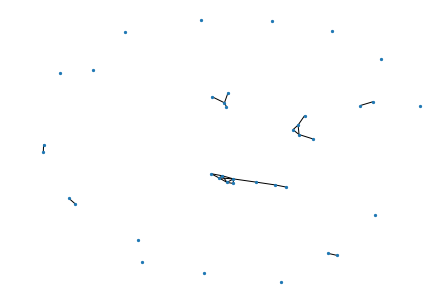

In [72]:
nx.draw(B, node_size=5)

In [73]:
class_df['color'] = [(r,g,b) for r,g,b in zip(class_df['r']/255, class_df['g']/255, class_df['b']/255)]

In [74]:
# block position adjustments
class_df.loc[21, 'x_pos'] = -1700
class_df.loc[9, 'y_pos'] = 0
class_df.loc[31, 'x_pos'] = 1500
class_df.loc[16, 'x_pos'] = 2900
class_df.loc[16, 'y_pos'] = 1700
class_df.loc[19, 'x_pos'] = 2300
class_df.loc[19, 'y_pos'] = -2500
class_df.loc[37, 'x_pos'] = 2000
class_df.loc[3, 'x_pos'] = -500
class_df.loc[3, 'y_pos'] = -2500
class_df.loc[35, 'x_pos'] = 100
class_df.loc[35, 'y_pos'] = -1700
class_df.loc[18, 'x_pos'] = -300
class_df.loc[18, 'y_pos'] = -1100
class_df.loc[5, 'x_pos'] = -800
class_df.loc[5, 'y_pos'] = -1400
class_df.loc[32, 'x_pos'] = -500

In [75]:
class_df['pos'] = [np.array([x,y]) for x, y in zip(class_df['x_pos'], class_df['y_pos'])]
layout = dict(class_df['pos'])

### Color blocks by stat_inf_class

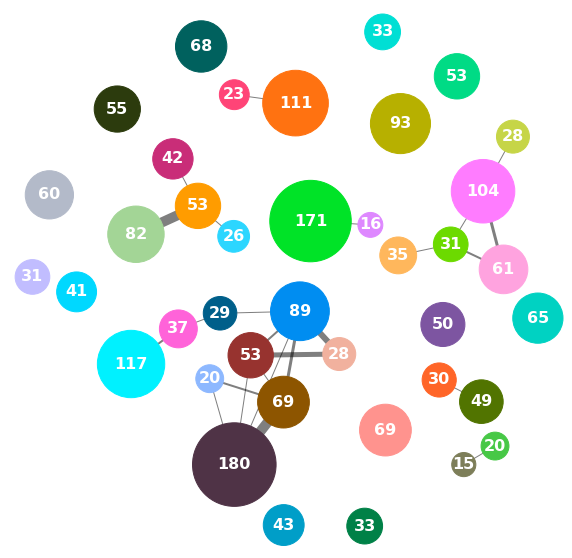

In [76]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0.97*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color=class_df.reindex(B.nodes)['color'].values)

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

# for adjusting placement
for node, pos in layout.items():
    ax.text(s=str(class_df.loc[node]['count']), 
            x=pos[0], y=pos[1], va='center', 
            ha='center', weight='bold', color='w', fontsize=16)

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240411_pubpeer_blockmodel_stat_inf_class.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_stat_inf_class.pdf', bbox_inches='tight')

(0.0, 10.0)

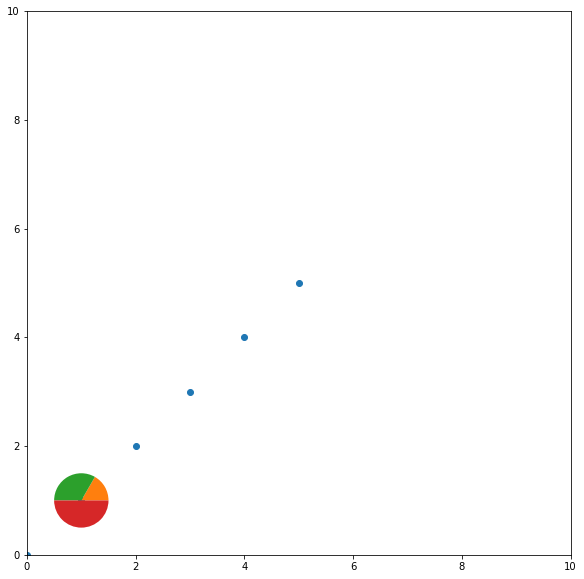

In [77]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

ax.scatter([0,1,2,3,4,5], [0,1,2,3,4,5])
ax.pie([2,4,6], center=[1,1], radius=0.5, frame=True)
ax.set_xlim([0,10])
ax.set_ylim([0,10])

### Pie chart blocks by prop retracted

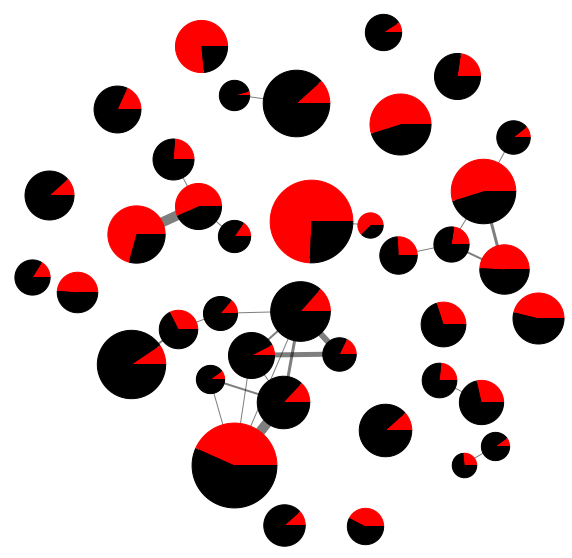

In [62]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0.8*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color='k')

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

for node in B.nodes:
    
    # make custom pie chart marker for retracted
    r1 = class_df.loc[node]['retracted']
    x1 = np.cos(2 * np.pi * np.linspace(0, r1))
    y1 = np.sin(2 * np.pi * np.linspace(0, r1))
    marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    
    ax.scatter(*layout.get(node), color='r', zorder=10, marker=marker,
               s=node_scale_factor*class_df.loc[node]['count'])
    
    # make custom pie chart marker for not retracted
    r1 = 1-class_df.loc[node]['retracted']
    x1 = np.cos(2 * np.pi * np.linspace(0, r1))
    y1 = -np.sin(2 * np.pi * np.linspace(0, r1))
    marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    
    ax.scatter(*layout.get(node), color='k', zorder=10, marker=marker,
               s=node_scale_factor*class_df.loc[node]['count'])
    #ax.pie(prop_df.loc[node][['retracted', 'not_retracted']].values, 
    #       center=layout.get(node), 
    #       radius=prop_df.loc[node]['total'], 
    #       colors=['r', 'b'])

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240411_pubpeer_blockmodel_retracted.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_retracted.pdf', bbox_inches='tight')

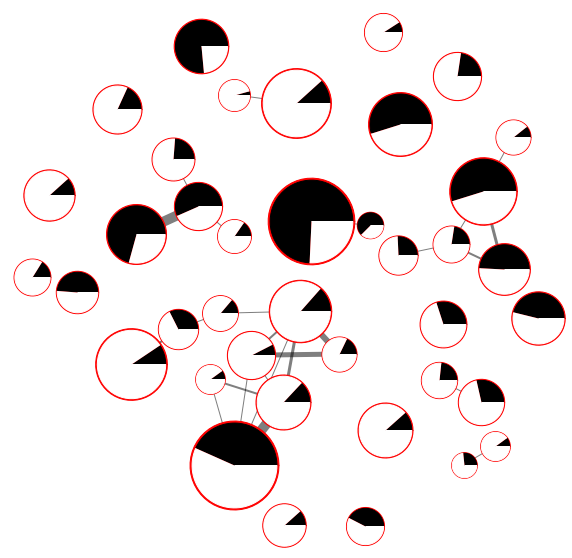

In [82]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0.8*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color='k')

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

for node in B.nodes:
    
    # make background
    r1 = 1
    x1 = np.cos(2 * np.pi * np.linspace(0, r1))
    y1 = np.sin(2 * np.pi * np.linspace(0, r1))
    marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    
    ax.scatter(*layout.get(node), color='r', zorder=10, marker=marker,
               s=1.1*node_scale_factor*class_df.loc[node]['count'])
    
    # make custom pie chart marker for retracted
    r1 = class_df.loc[node]['retracted']
    x1 = np.cos(2 * np.pi * np.linspace(0, r1))
    y1 = np.sin(2 * np.pi * np.linspace(0, r1))
    marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    
    ax.scatter(*layout.get(node), color='k', zorder=10, marker=marker,
               s=node_scale_factor*class_df.loc[node]['count'])
    
    # make custom pie chart marker for not retracted
    r1 = 1-class_df.loc[node]['retracted']
    x1 = np.cos(2 * np.pi * np.linspace(0, r1))
    y1 = -np.sin(2 * np.pi * np.linspace(0, r1))
    marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    
    ax.scatter(*layout.get(node), color='w', zorder=10, marker=marker,
               s=node_scale_factor*class_df.loc[node]['count'])
    #ax.pie(prop_df.loc[node][['retracted', 'not_retracted']].values, 
    #       center=layout.get(node), 
    #       radius=prop_df.loc[node]['total'], 
    #       colors=['r', 'b'])

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240620_pubpeer_blockmodel_retracted.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240620_pubpeer_blockmodel_retracted.pdf', bbox_inches='tight')

In [79]:
r1

0.9090909090909091

In [59]:
prop_df['retracted'].mean()

0.3411658382286489

### Color blocks by publisher entropy p value

In [63]:
class_df['log_p'] = np.log10(class_df['stat_inf_entropy_p'])

In [64]:
cmap = plt.cm.Reds_r
norm = mpl.colors.Normalize(vmin=-5, vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

In [65]:
class_df['p_color'] = [tuple(x) for x in cmap(norm(class_df['log_p']))]

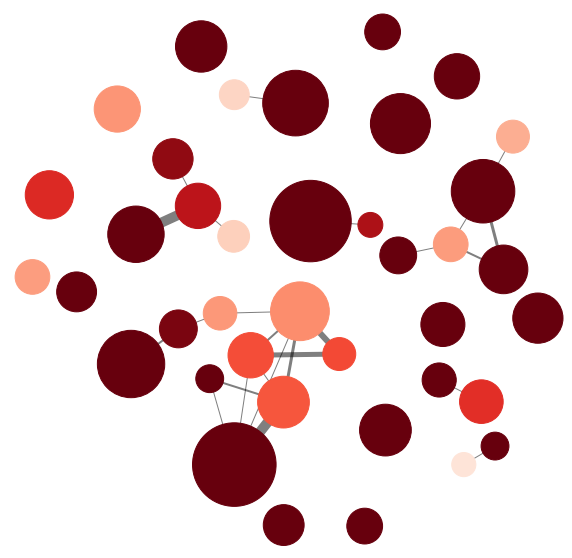

In [66]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0.97*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color=class_df.reindex(B.nodes)['p_color'].values)

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

# for adjusting placement
#for node, pos in layout.items():
#    ax.text(s=str(node), x=pos[0], y=pos[1])

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

#fig.colorbar(sm)

fig.savefig('../img/240411_pubpeer_blockmodel_p.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_p.pdf', bbox_inches='tight')

### Color blocks by year entropy p value

In [67]:
class_df['log_p'] = np.log10(class_df['year_entropy_p'])

In [68]:
cmap = plt.cm.Reds_r
norm = mpl.colors.Normalize(vmin=-5, vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

In [69]:
class_df['p_color'] = [tuple(x) for x in cmap(norm(class_df['log_p']))]

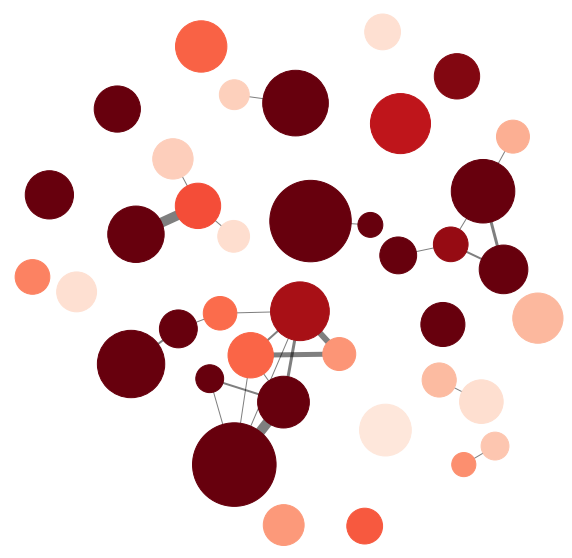

In [70]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0.97*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color=class_df.reindex(B.nodes)['p_color'].values)

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

# for adjusting placement
#for node, pos in layout.items():
#    ax.text(s=str(node), x=pos[0], y=pos[1])

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

#fig.colorbar(sm)

fig.savefig('../img/240411_pubpeer_blockmodel_year_p.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_year_p.pdf', dpi=200, bbox_inches='tight')

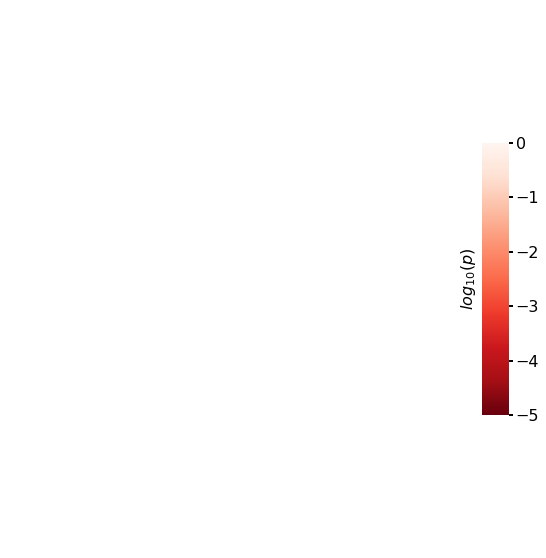

In [62]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cbar = plt.colorbar(sm, aspect=10, fraction=0.15, shrink=0.5)
[cbar.ax.spines[spine].set_visible(False) for spine in cbar.ax.spines]
cbar.ax.set_yticks(np.arange(0,-6,-1))
cbar.ax.tick_params(labelsize=16, width=2)
cbar.ax.yaxis.set_label_position("left")
cbar.ax.set_ylabel(r'$log_{10}(p)$', fontsize=16)
ax.axis('off')
fig.savefig('../img/240411_pubpeer_blockmodel_p_color.png', dpi=200, bbox_inches='tight')

### Pie chart blocks by Publisher

In [72]:
global_publisher_distribution = prop_df['publisher'].value_counts()

In [73]:
global_publisher_distribution.head(8).index

Index(['Springer Science and Business Media LLC', 'Spandidos Publications',
       'Wiley', 'Elsevier BV', 'Informa UK Limited', 'Impact Journals, LLC',
       'BAKIS Productions LTD', 'Verduci Editore s.r.l.'],
      dtype='object')

In [74]:
prop_df['publisher_label'] = prop_df['publisher']
prop_df.loc[~prop_df['publisher'].isin(global_publisher_distribution.head(8).index), 'publisher_label'] = 'Other'

In [75]:
publisher_count_df = prop_df.groupby(['stat_inf_class', 'publisher_label']).count()['Id'].reset_index()\
.pivot(index='stat_inf_class', columns='publisher_label', values='Id').fillna(0.0)
publisher_count_df = (publisher_count_df.T/publisher_count_df.sum(axis=1)).T

In [76]:
publisher_count_df = publisher_count_df[list(global_publisher_distribution.head(8).index) + ['Other']]

In [77]:
prop_df['publisher_label'].value_counts()/len(prop_df)

Other                                      0.242
Springer Science and Business Media LLC    0.162
Spandidos Publications                     0.151
Wiley                                      0.112
Elsevier BV                                0.097
Informa UK Limited                         0.085
Impact Journals, LLC                       0.075
BAKIS Productions LTD                      0.049
Verduci Editore s.r.l.                     0.026
Name: publisher_label, dtype: float64

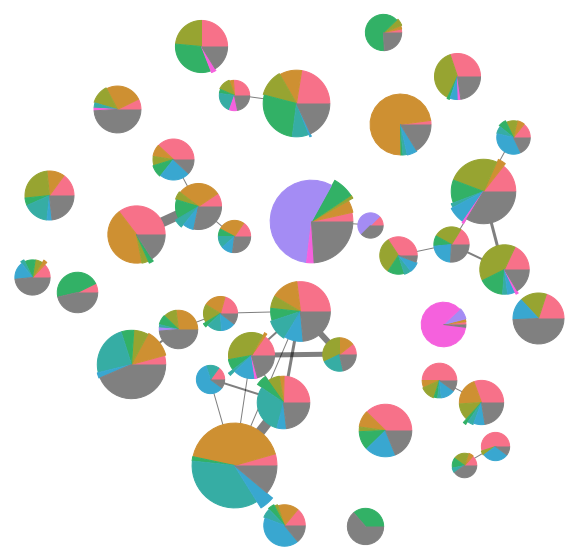

In [107]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color='k')

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

for node in B.nodes:
    r0 = 0
    for publisher, color in zip(publisher_count_df.columns, sns.color_palette("husl", 8) + ['grey']):
        # make custom pie chart marker for retracted
        r1 = publisher_count_df.loc[node][publisher]
        if r1 > 0:
            x1 = np.cos(2 * np.pi * np.linspace(r0, r0+r1, 100))
            y1 = np.sin(2 * np.pi * np.linspace(r0, r0+r1, 100))
            marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])

            ax.scatter(*layout.get(node), color=color, zorder=10, marker=marker,
                       s=node_scale_factor*class_df.loc[node]['count'])
        r0 += r1
        #print(node_scale_factor*class_df.loc[node]['count'])
    #ax.pie(prop_df.loc[node][['retracted', 'not_retracted']].values, 
    #       center=layout.get(node), 
    #       radius=prop_df.loc[node]['total'], 
    #       colors=['r', 'b'])

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240411_pubpeer_blockmodel_publisher.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_publisher.pdf', bbox_inches='tight')

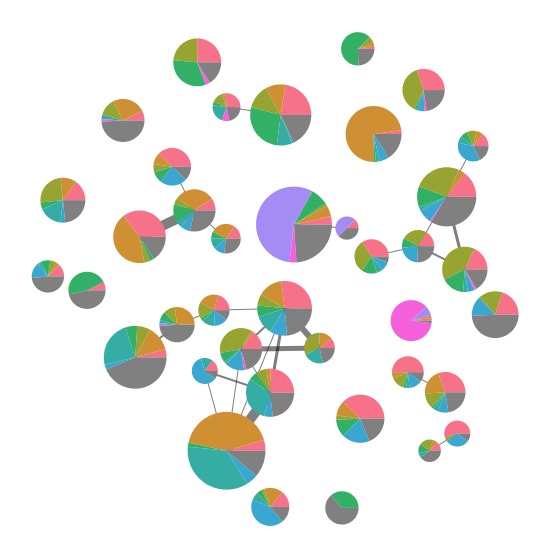

In [108]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color='k')

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

for node in B.nodes:
    r0 = 0
    for publisher, color in zip(publisher_count_df.columns, sns.color_palette("husl", 8) + ['grey']):
        # make custom pie chart marker for retracted
        r1 = publisher_count_df.loc[node][publisher]
        if r1 > 0:
            x1 = np.cos(2 * np.pi * np.linspace(r0, r0+r1, 100))
            y1 = np.sin(2 * np.pi * np.linspace(r0, r0+r1, 100))
            marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])

            #ax.scatter(*layout.get(node), color=color, zorder=10, marker=marker,
            #           s=node_scale_factor*class_df.loc[node]['count'])
        r0 += r1
        
        #print(node_scale_factor*class_df.loc[node]['count'])
    ax.pie(publisher_count_df.loc[node].values, 
           center=layout.get(node), 
           radius=node_scale_factor*np.sqrt(class_df.loc[node]['count']), 
           colors=sns.color_palette("husl", 8) + ['grey'], frame=True)

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240411_pubpeer_blockmodel_publisher.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_publisher.pdf', bbox_inches='tight')

In [83]:
sns.color_palette("husl", 8)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

### Pie chart plots by Year

In [101]:
prop_df['label_year'] = prop_df['pub_year']
prop_df.loc[prop_df['pub_year'] <= 2012, 'label_year'] = 2012
prop_df.loc[prop_df['pub_year'] >= 2022, 'label_year'] = 2022

In [102]:
year_count_df = prop_df.groupby(['stat_inf_class', 'label_year']).count()['Id'].reset_index()\
.pivot(index='stat_inf_class', columns='label_year', values='Id').fillna(0.0)
year_count_df = (year_count_df.T/year_count_df.sum(axis=1)).T

In [103]:
prop_df.groupby('label_year').count()['Id']/len(prop_df)

label_year
2012    0.009
2013    0.014
2014    0.035
2015    0.069
2016    0.092
2017    0.116
2018    0.165
2019    0.207
2020    0.206
2021    0.064
2022    0.023
Name: Id, dtype: float64

In [104]:
custom_1 = mpl.colors.LinearSegmentedColormap.from_list('custom_1', ['lightgrey', 'blue'], N=1_000)

In [105]:
cmap = custom_1#plt.cm.spring
norm = mpl.colors.Normalize(vmin=0, vmax=1)

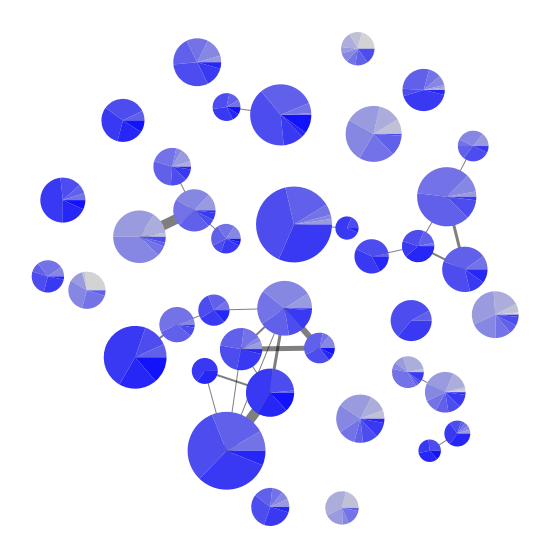

In [106]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

node_scale_factor = 40

#draw nodes
node_patch = nx.draw_networkx_nodes(B, pos=layout, 
                                    node_size=0*node_scale_factor*class_df.reindex(B.nodes)['count'].values, 
                                    ax=ax, node_color='k')

# draw edges
edge_patch = nx.draw_networkx_edges(B, pos=layout, ax=ax, 
                                    node_size=node_scale_factor*class_df.reindex(B.nodes)['count'].values,
                                    arrows=False, connectionstyle='arc3,rad=0.2', alpha=0.5,
                                    width=[1*value for key, value in nx.get_edge_attributes(B, 'weight').items()])

for node in B.nodes:
    r0 = 0
    for publisher, color in zip(year_count_df.columns, cmap(norm(np.arange(0.0,1.05,1/11)))):
        # make custom pie chart marker for retracted
        r1 = year_count_df.loc[node][publisher]
        if r1 > 0:
            x1 = np.cos(2 * np.pi * np.linspace(r0, r0+r1, 100))
            y1 = np.sin(2 * np.pi * np.linspace(r0, r0+r1, 100))
            marker = np.row_stack([[0, 0], np.column_stack([x1, y1])])

            #ax.scatter(*layout.get(node), color=color, zorder=10, marker=marker,
            #           s=node_scale_factor*class_df.loc[node]['count'])
        r0 += r1
        #print(node_scale_factor*class_df.loc[node]['count'])
    ax.pie(year_count_df.loc[node].values, 
           center=layout.get(node), 
           radius=node_scale_factor*np.sqrt(class_df.loc[node]['count']), 
           colors=cmap(norm(np.arange(0.0,1.05,1/11))), frame=True)

ax.axis('off')
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]+25])

fig.savefig('../img/240411_pubpeer_blockmodel_pub_year.png', dpi=200, bbox_inches='tight')
fig.savefig('../img/240411_pubpeer_blockmodel_pub_year.pdf', bbox_inches='tight')

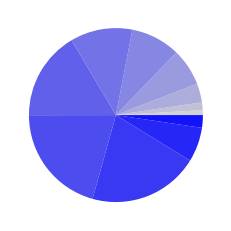

In [212]:
plt.pie(prop_df.groupby('label_year').count()['Id'], colors=cmap(norm(np.arange(0.0,1.05,1/11))))
plt.savefig('../img/2404011_pubpeer_publisher_year_global.png', dpi=200)

In [208]:
prop_df.groupby('label_year').count()['Id'].shape

(11,)